In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc, classification_report

import warnings
from sklearn.exceptions import ConvergenceWarning

# Корисні функції

In [2]:
def get_f1_score(target, preds, name=''):
    f1_score_ = f1_score(target, preds)
    print(f"F1 score {name}: {f1_score_:.2f}%")

In [3]:
def predict_and_plot(y_train, y_test, y_train_pred, y_test_pred):   
    plt.figure(figsize=(10, 3))
     
    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Training accuracy: {:.2f}%".format(accuracy_train * 100))
    get_f1_score(y_train, y_train_pred, 'Training')

    accuracy_test = accuracy_score(y_test, y_test_pred)
    print("Test accuracy: {:.2f}%".format(accuracy_test * 100))
    get_f1_score(y_test, y_test_pred, 'Test')

    plt.subplot(1, 2, 1)
    cf_train = confusion_matrix(y_train, y_train_pred, normalize='true')
    sns.heatmap(cf_train, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Training Confusion Matrix');

    plt.subplot(1, 2, 2)
    cf_train = confusion_matrix(y_test, y_test_pred, normalize='true')
    sns.heatmap(cf_train, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Test Confusion Matrix');

In [4]:
def compute_auroc_and_build_roc(inputs, targets, model, name=''):
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.4f}')

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def get_report(targets_train, preds_train, targets_test, preds_test):
    print('Training')
    print(classification_report(targets_train, preds_train, digits = 4))
    print('\nTest')
    print(classification_report(targets_test, preds_test, digits = 4))

# Завдання 1

## 1. Завантажте вбудований датасет load_breast_cancer з бібліотеки sklearn.datasets

In [72]:
breast_cancer_sklearn = load_breast_cancer()

df_breast_cancer = pd.DataFrame(data = breast_cancer_sklearn.data,
                           columns = breast_cancer_sklearn.feature_names)

df_breast_cancer['target'] = breast_cancer_sklearn.target

In [73]:
df_breast_cancer['target']

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int32

## 2. Проведіть попередній аналіз

In [74]:
# Перегляд перших 5 рядків

df_breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [75]:
df_breast_cancer[df_breast_cancer['target'] == 1]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
19,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,0.05766,...,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259,1
20,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,0.06811,...,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183,1
21,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,0.06905,...,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773,1
37,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,0.05863,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,1
46,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,0.06503,...,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,14.590,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.037360,0.1454,0.06147,...,27.27,105.90,733.5,0.10260,0.31710,0.36620,0.11050,0.2258,0.08004,1
559,11.510,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.041050,0.1388,0.06570,...,37.16,82.28,474.2,0.12980,0.25170,0.36300,0.09653,0.2112,0.08732,1
560,14.050,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.043040,0.1537,0.06171,...,33.17,100.20,706.7,0.12410,0.22640,0.13260,0.10480,0.2250,0.08321,1
561,11.200,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.000000,0.1060,0.05502,...,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905,1


In [76]:
# Перевірка назви стовпців

df_breast_cancer.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [77]:
df_breast_cancer.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0


In [78]:
# Перевірка типів даних

for c in df_breast_cancer.columns:
    print(f"{c} :", df_breast_cancer[c].dtype)

mean radius : float64
mean texture : float64
mean perimeter : float64
mean area : float64
mean smoothness : float64
mean compactness : float64
mean concavity : float64
mean concave points : float64
mean symmetry : float64
mean fractal dimension : float64
radius error : float64
texture error : float64
perimeter error : float64
area error : float64
smoothness error : float64
compactness error : float64
concavity error : float64
concave points error : float64
symmetry error : float64
fractal dimension error : float64
worst radius : float64
worst texture : float64
worst perimeter : float64
worst area : float64
worst smoothness : float64
worst compactness : float64
worst concavity : float64
worst concave points : float64
worst symmetry : float64
worst fractal dimension : float64
target : int32


In [79]:
numeric_cols = df_breast_cancer.select_dtypes(include = np.number).columns.tolist()
cat_cols     = df_breast_cancer.select_dtypes(include = 'object').columns.tolist()

In [80]:
numeric_cols, cat_cols

(['mean radius',
  'mean texture',
  'mean perimeter',
  'mean area',
  'mean smoothness',
  'mean compactness',
  'mean concavity',
  'mean concave points',
  'mean symmetry',
  'mean fractal dimension',
  'radius error',
  'texture error',
  'perimeter error',
  'area error',
  'smoothness error',
  'compactness error',
  'concavity error',
  'concave points error',
  'symmetry error',
  'fractal dimension error',
  'worst radius',
  'worst texture',
  'worst perimeter',
  'worst area',
  'worst smoothness',
  'worst compactness',
  'worst concavity',
  'worst concave points',
  'worst symmetry',
  'worst fractal dimension',
  'target'],
 [])

Всі стовпці мають числовий тип даних, змінювати нічого непотрібно. Стовпців із типом даних 'object' немає

In [81]:
# Перевірка наявності пропущених значень

df_breast_cancer.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [82]:
for c in df_breast_cancer.columns:
    if df_breast_cancer[c].isna().sum() != 0:
        print(c)

Отже, пропущених значень немає

In [83]:
# розмір даних

df_breast_cancer.shape

(569, 31)

In [84]:
# Перевірка на наявність дублікатів

df_breast_cancer.duplicated().sum()

0

## 3. Побудова та налаштування моделей

### Побудова трьох моделей класифікації та підбір гіперпараметрів

#### Логістична регресія

Training accuracy: 96.70%
F1 score Training: 0.97%
Test accuracy: 97.37%
F1 score Test: 0.98%
AUROC for Training: 0.9930


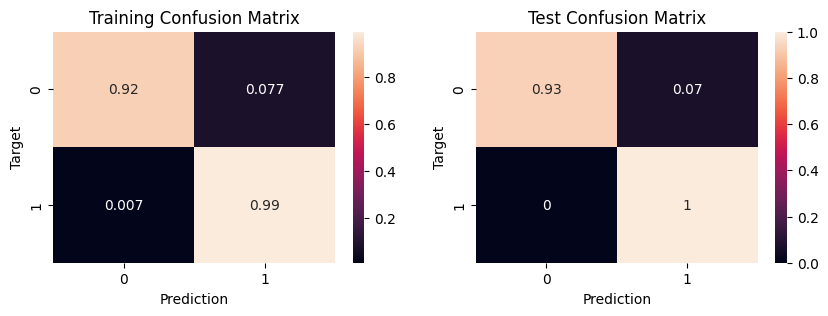

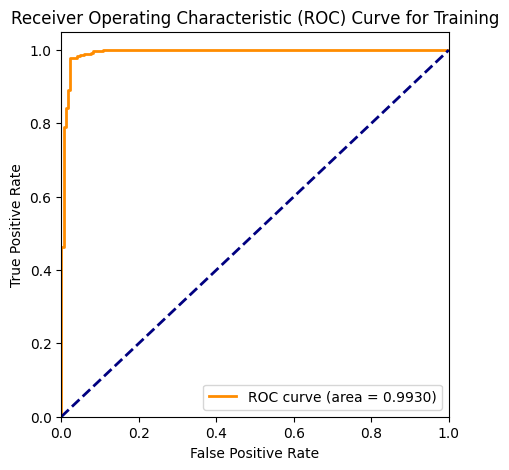

AUROC for Test: 0.9980


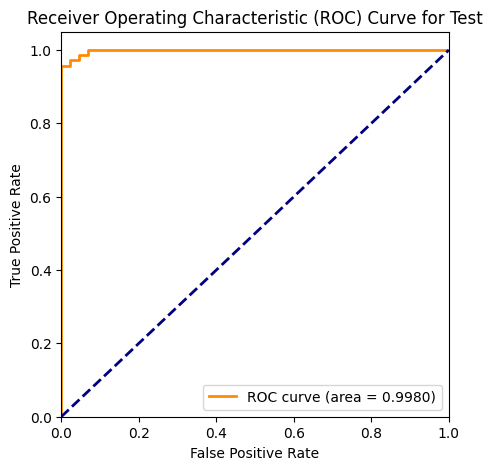

In [85]:
# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(df_breast_cancer.drop(columns = ['target']), 
                                                    df_breast_cancer['target'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Масштабування ознак
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

# Створення та тренування моделі
model_log = LogisticRegression(solver = 'liblinear')
model_log.fit(X_train, y_train)

# Прогнозування моделі
train_pred_logistic = model_log.predict(X_train)
test_pred_logistic  = model_log.predict(X_test)

# Оцінка моделі
predict_and_plot(y_train, y_test, train_pred_logistic, test_pred_logistic)
compute_auroc_and_build_roc(X_train, y_train, model_log, 'Training')
compute_auroc_and_build_roc(X_test, y_test, model_log, 'Test')

Бачимо, що точність доволі висока і на тренувальних, і на тестувальних даних. Модель не перенавчена.

Найкращі параметри для логістичної регресії: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Training accuracy: 98.46%
F1 score Training: 0.99%
Test accuracy: 97.37%
F1 score Test: 0.98%
AUROC for Training: 0.9963


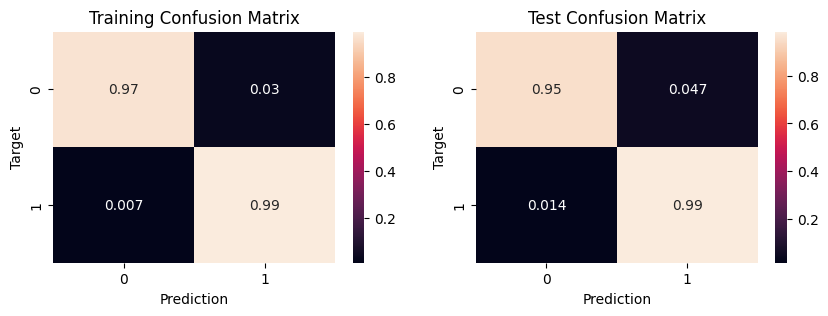

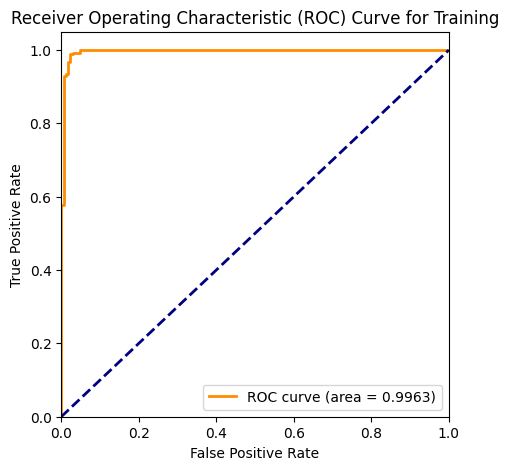

AUROC for Test: 0.9974


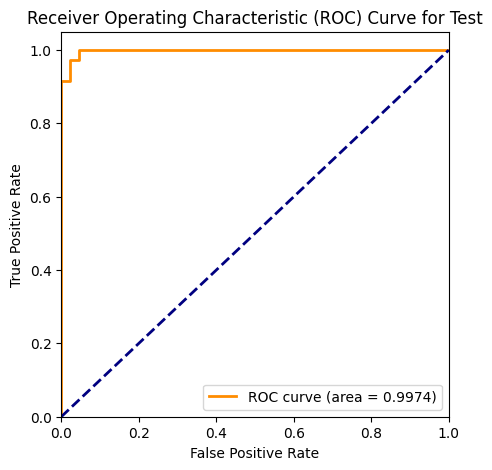

In [62]:
# Підбір гіперпараметрів

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    warnings.simplefilter("ignore", UserWarning)

    log_reg = LogisticRegression(max_iter = 1000)

    parameters = [
        {'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
        {'solver': ['saga'], 'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}  # 'l1_ratio' тільки для elasticnet
    ]

    model_log_grid = GridSearchCV(estimator = log_reg, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose = 0)

    model_log_grid.fit(X_train, y_train)

    log_best_model = model_log_grid.best_estimator_

    train_pred_log_grid = log_best_model.predict(X_train)
    test_pred_log_grid  = log_best_model.predict(X_test)

    print("Найкращі параметри для логістичної регресії:", model_log_grid.best_params_)

    predict_and_plot(y_train, y_test, train_pred_log_grid, test_pred_log_grid)
    compute_auroc_and_build_roc(X_train, y_train, model_log_grid, 'Training')
    compute_auroc_and_build_roc(X_test, y_test, model_log_grid, 'Test')

Точність також доволі висока і на тренувальних, і на тестувальних даних. Модель не перенавчена.

#### Random Forest

In [54]:
# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(df_breast_cancer.drop(columns = ['target']), 
                                                    df_breast_cancer['target'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Створення моделі
model_rnd_clf = RandomForestClassifier(n_estimators = 5,
                                       max_leaf_nodes = 16,
                                       n_jobs = -1,
                                       random_state = 42)

# Тренування моделі
model_rnd_clf.fit(X_train, y_train)

# Прогнозування моделі
train_pred_rnd_clf = model_rnd_clf.predict(X_train)
test_pred_rnd_clf  = model_rnd_clf.predict(X_test)

# Оцінка моделі
get_report(y_train, train_pred_rnd_clf, y_test, test_pred_rnd_clf)

Training
              precision    recall  f1-score   support

           0     0.9940    0.9822    0.9881       169
           1     0.9896    0.9965    0.9930       286

    accuracy                         0.9912       455
   macro avg     0.9918    0.9894    0.9906       455
weighted avg     0.9912    0.9912    0.9912       455


Test
              precision    recall  f1-score   support

           0     0.9318    0.9535    0.9425        43
           1     0.9714    0.9577    0.9645        71

    accuracy                         0.9561       114
   macro avg     0.9516    0.9556    0.9535       114
weighted avg     0.9565    0.9561    0.9562       114



In [64]:
# Підбір гіперпараметрів

rf = RandomForestClassifier(random_state = 42)
params_rf = {
    'n_estimators': [1, 5, 10, 50, 100, 200],
    'max_leaf_nodes':[4, 8, 16, 32]
}

model_rnd_clf_gridsearch = GridSearchCV(rf, params_rf, cv = 5)
model_rnd_clf_gridsearch.fit(X_train, y_train)

rf_best_model = model_rnd_clf_gridsearch.best_estimator_

train_pred_rnd_clf_gridsearch = rf_best_model.predict(X_train)
test_pred_rnd_clf_gridsearch  = rf_best_model.predict(X_test)

print("Найкращі параметри для Random forest:", model_rnd_clf_gridsearch.best_params_)

get_report(y_train, train_pred_rnd_clf_gridsearch, y_test, test_pred_rnd_clf_gridsearch)

Найкращі параметри для Random forest: {'max_leaf_nodes': 32, 'n_estimators': 50}
Training
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       169
           1     1.0000    1.0000    1.0000       286

    accuracy                         1.0000       455
   macro avg     1.0000    1.0000    1.0000       455
weighted avg     1.0000    1.0000    1.0000       455


Test
              precision    recall  f1-score   support

           0     0.9756    0.9302    0.9524        43
           1     0.9589    0.9859    0.9722        71

    accuracy                         0.9649       114
   macro avg     0.9673    0.9581    0.9623       114
weighted avg     0.9652    0.9649    0.9647       114



Training accuracy: 99.34%
F1 score Training: 0.99%
Test accuracy: 96.49%
F1 score Test: 0.97%
AUROC for Training: 1.0000


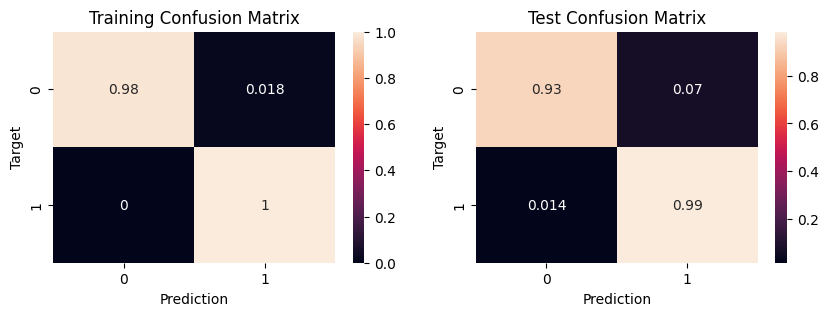

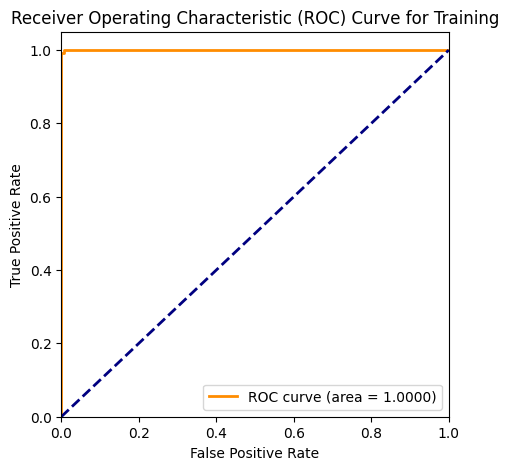

AUROC for Test: 0.9941


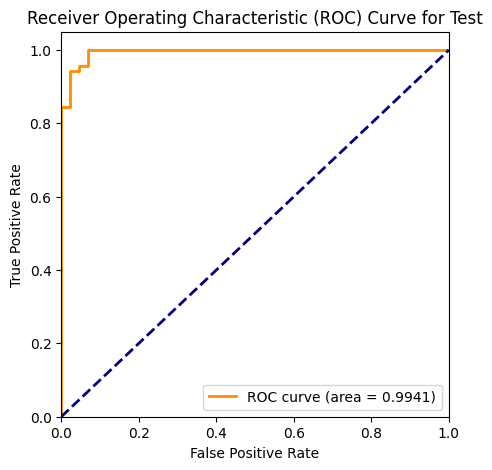

In [56]:
predict_and_plot(y_train, y_test, train_pred_rnd_clf_gridsearch, test_pred_rnd_clf_gridsearch)
compute_auroc_and_build_roc(X_train, y_train, rf_best_model, 'Training')
compute_auroc_and_build_roc(X_test, y_test, rf_best_model, 'Test')

Бачимо, що після підбору гіперпараметрів точність моделі на тестових даних підвищилась, але модель все ще трохи перенавчена.

#### Decision Tree

Training
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       169
           1     1.0000    1.0000    1.0000       286

    accuracy                         1.0000       455
   macro avg     1.0000    1.0000    1.0000       455
weighted avg     1.0000    1.0000    1.0000       455


Test
              precision    recall  f1-score   support

           0     0.9302    0.9302    0.9302        43
           1     0.9577    0.9577    0.9577        71

    accuracy                         0.9474       114
   macro avg     0.9440    0.9440    0.9440       114
weighted avg     0.9474    0.9474    0.9474       114

Training accuracy: 100.00%
F1 score Training: 1.00%
Test accuracy: 94.74%
F1 score Test: 0.96%
AUROC for Training: 1.0000


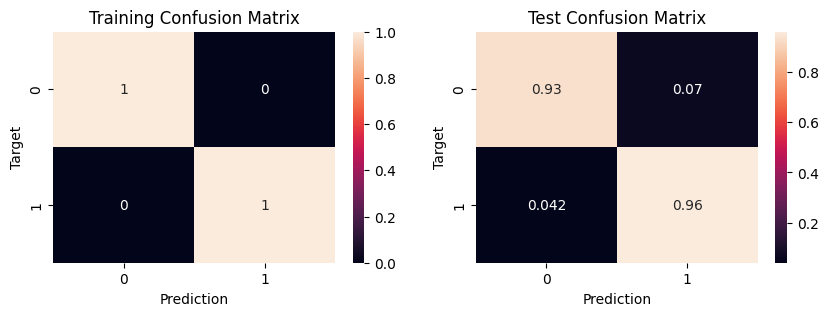

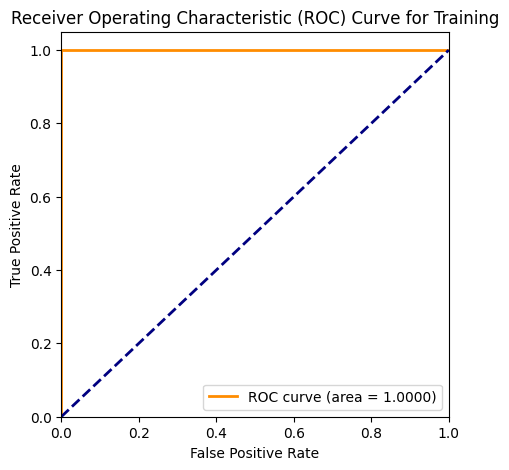

AUROC for Test: 0.9440


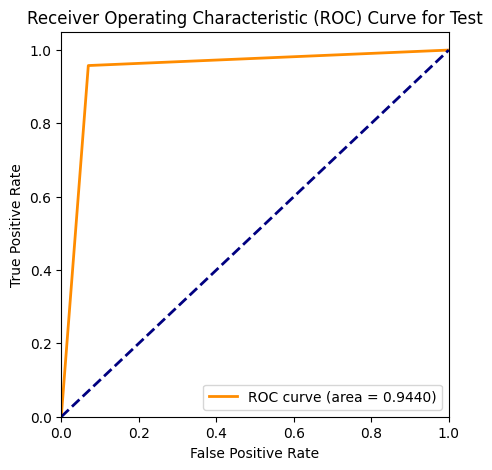

In [57]:
# Розділення даних на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(df_breast_cancer.drop(columns = ['target']), 
                                                    df_breast_cancer['target'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Препроцесинг даних
scaler  = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

# Створення та тренування моделі
model_dt = DecisionTreeClassifier(random_state = 42)
model_dt.fit(X_train, y_train)

# Прогнозування моделі
train_pred_dt = model_dt.predict(X_train)
test_pred_dt  = model_dt.predict(X_test)

# Оцінка моделі
get_report(y_train, train_pred_dt, y_test, test_pred_dt)
predict_and_plot(y_train, y_test, train_pred_dt, test_pred_dt)
compute_auroc_and_build_roc(X_train, y_train, model_dt, 'Training')
compute_auroc_and_build_roc(X_test, y_test, model_dt, 'Test')

Бачимо, що на тренувальних даних модель прогнозує ідеально, а на тестувальних, хоч і точність доволі висока, але модель припускає помилки. Тому, наразі є перенавчання.

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Найкращі параметри для Decision tree: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Training accuracy: 98.90%
F1 score Training: 0.99%
Test accuracy: 95.61%
F1 score Test: 0.97%
AUROC for Training: 0.9994


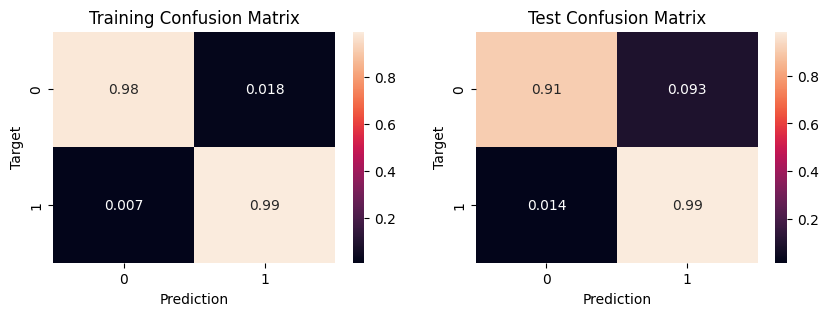

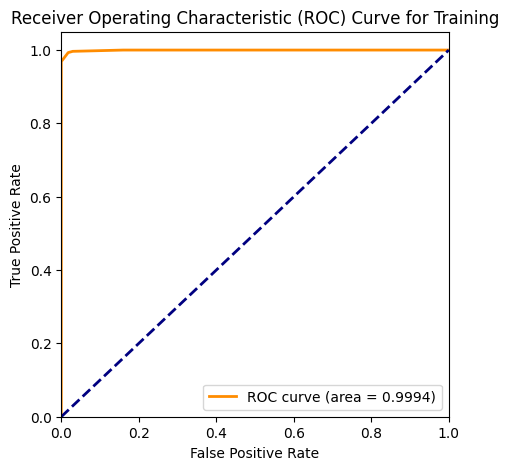

AUROC for Test: 0.9440


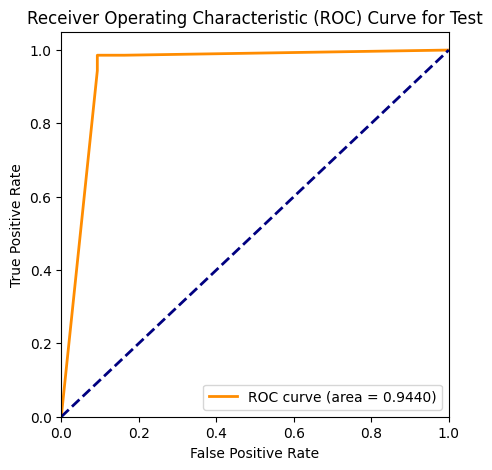

In [63]:
# Підбір гіперпараметрів

dt = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_features': [None, 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' : ['gini', 'entropy']
             }

model_dt_grid = GridSearchCV(estimator = dt, param_grid = param_grid, cv = 5, verbose = True)
model_dt_grid.fit(X_train, y_train)

dt_best_model = model_dt_grid.best_estimator_

train_pred_dt_grid = dt_best_model.predict(X_train)
test_pred_dt_grid  = dt_best_model.predict(X_test)

print("Найкращі параметри для Decision tree:", model_dt_grid.best_params_)

predict_and_plot(y_train, y_test, train_pred_dt_grid, test_pred_dt_grid)
compute_auroc_and_build_roc(X_train, y_train, model_dt_grid, 'Training')
compute_auroc_and_build_roc(X_test, y_test, model_dt_grid, 'Test')

Модель непогано прогнозує, але є невелике перенавчання.

## 4. Висновки

In [88]:
train_accuracy_log      = accuracy_score(y_train, train_pred_logistic)
train_accuracy_log_grid = accuracy_score(y_train, train_pred_log_grid)
train_accuracy_rf       = accuracy_score(y_train, train_pred_rnd_clf)
train_accuracy_rf_grid  = accuracy_score(y_train, train_pred_rnd_clf_gridsearch)
train_accuracy_dt       = accuracy_score(y_train, train_pred_dt)
train_accuracy_dt_grid  = accuracy_score(y_train, train_pred_dt_grid)

train_f1_log      = f1_score(y_train, train_pred_logistic)
train_f1_log_grid = f1_score(y_train, train_pred_log_grid)
train_f1_rf       = f1_score(y_train, train_pred_rnd_clf)
train_f1_rf_grid  = f1_score(y_train, train_pred_rnd_clf_gridsearch)
train_f1_dt       = f1_score(y_train, train_pred_dt)
train_f1_dt_grid  = f1_score(y_train, train_pred_dt_grid)

test_accuracy_log      = accuracy_score(y_test, test_pred_logistic)
test_accuracy_log_grid = accuracy_score(y_test, test_pred_log_grid)
test_accuracy_rf       = accuracy_score(y_test, test_pred_rnd_clf)
test_accuracy_rf_grid  = accuracy_score(y_test, test_pred_rnd_clf_gridsearch)
test_accuracy_dt       = accuracy_score(y_test, test_pred_dt)
test_accuracy_dt_grid  = accuracy_score(y_test, test_pred_dt_grid)

test_f1_log      = f1_score(y_test, test_pred_logistic)
test_f1_log_grid = f1_score(y_test, test_pred_log_grid)
test_f1_rf       = f1_score(y_test, test_pred_rnd_clf)
test_f1_rf_grid  = f1_score(y_test, test_pred_rnd_clf_gridsearch)
test_f1_dt       = f1_score(y_test, test_pred_dt)
test_f1_dt_grid  = f1_score(y_test, test_pred_dt_grid)

In [89]:
results = pd.DataFrame({
    'Model' : ['Logistic Regression', 'Logistic Regression GridSearch', 'Random Forest', 'Random Forest GridSearch', 'Decision Tree', 'Decision Tree GridSearch'],
    'Train Accuracy' : [train_accuracy_log, train_accuracy_log_grid, train_accuracy_rf, train_accuracy_rf_grid, train_accuracy_dt, train_accuracy_dt_grid],
    'Test Accuracy' : [test_accuracy_log, test_accuracy_log_grid, test_accuracy_rf, test_accuracy_rf_grid, test_accuracy_dt, test_accuracy_dt_grid],
    'Train F1 Score' : [train_f1_log, train_f1_log_grid, train_f1_rf, train_f1_rf_grid, train_f1_dt, train_f1_dt_grid],
    'Test F1 score' : [test_f1_log, test_f1_log_grid, test_f1_rf, test_f1_rf_grid, test_f1_dt, test_f1_dt_grid]
})

display(results)

,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 score
0,Logistic Regression,0.967033,0.973684,0.974271,0.979310
1,Logistic Regression GridSearch,0.984615,0.973684,0.987826,0.979021
2,Random Forest,0.991209,0.956140,0.993031,0.964539
3,Random Forest GridSearch,1.000000,0.964912,1.000000,0.972222
4,Decision Tree,1.000000,0.947368,1.000000,0.957746
5,Decision Tree GridSearch,0.989011,0.956140,0.991274,0.965517


Отже, бачимо, що найкраще прогнозує модель логістичної регресії із підібраними гіперпараметрами за допомогою GridSearch. Модель Logistic Regression GridSearch має найвищу точність та найвищий параметр F1 score. Також, модель не перенавчена.

# Завдання 2

In [21]:
# Читання та створення датасету
df_titanic = pd.read_csv('titanic.csv')

df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Попередній аналіз датасету

In [22]:
# Розмір датасету
df_titanic.shape

(418, 12)

In [23]:
# Виведення назв стовпців
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [24]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [25]:
# Перевірка наявності пропущених значень
df_titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [26]:
# Заміна пропущених значень на середнє або видалення стовпця
df_titanic['Age'].fillna(df_titanic['Age'].mean(skipna = True), inplace = True)
df_titanic['Fare'].fillna(df_titanic['Fare'].mean(skipna = True), inplace = True)
df_titanic.drop('Cabin', axis = 1, inplace = True)

In [31]:
# Перевірка наявності дублікатів
df_titanic.duplicated().sum()

0

## Побудова та налаштування моделей

In [54]:
# Розділення даних на тренувальний та тестовий набори
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(df_titanic.drop(columns = ['Survived']), 
                                                            df_titanic['Survived'], 
                                                            test_size = 0.2, 
                                                            random_state = 42)

# Я вважаю, що ID пасажиру, ім'я пасажиру та номер білету ніяк не впливають на те, чи вижила людина, тому надалі ці три стовпці використовувати не буду
X_train_t.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
X_test_t.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)

# Визначення числових та категоріальних колонок
numeric_cols = X_train_t.select_dtypes(include = np.number).columns.tolist()
cat_cols     = X_train_t.select_dtypes(include = 'object').columns.tolist()

# Масштабування числових ознак
scaler = MinMaxScaler()

scaler.fit(X_train_t[numeric_cols])

X_train_t[numeric_cols] = scaler.fit_transform(X_train_t[numeric_cols])
X_test_t[numeric_cols]  = scaler.transform(X_test_t[numeric_cols])

# Кодування категоріальних ознак
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

encoder.fit(X_train_t[cat_cols])

encoded_cols = list(encoder.get_feature_names_out(cat_cols))

X_train_t[encoded_cols] = encoder.transform(X_train_t[cat_cols])
X_test_t[encoded_cols]  = encoder.transform(X_test_t[cat_cols])

# Визначення тренувального та валідаційного наборів із масштабованими колонками
X_train_t = X_train_t[numeric_cols + encoded_cols]
X_test_t  = X_test_t[numeric_cols + encoded_cols]

### Логістична регресія

Training accuracy: 100.00%
F1 score Training: 1.00%
Test accuracy: 100.00%
F1 score Test: 1.00%
AUROC for Training: 1.0000


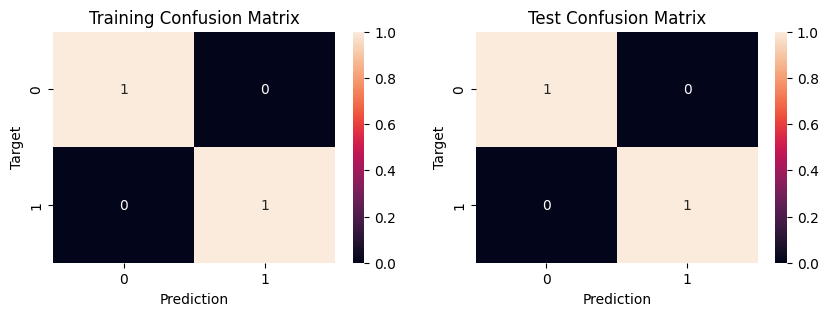

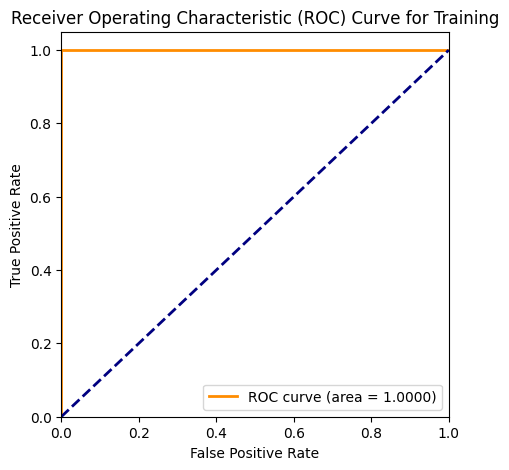

AUROC for Test: 1.0000


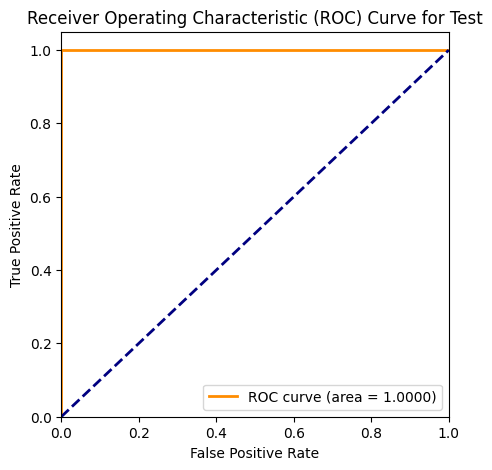

In [55]:
# Створення та тренування моделі
model_log_t = LogisticRegression(solver = 'liblinear')
model_log_t.fit(X_train_t, y_train_t)

# Прогнозування моделі
train_pred_logistic_t = model_log_t.predict(X_train_t)
test_pred_logistic_t  = model_log_t.predict(X_test_t)

# Оцінка моделі
predict_and_plot(y_train_t, y_test_t, train_pred_logistic_t, test_pred_logistic_t)
compute_auroc_and_build_roc(X_train_t, y_train_t, model_log_t, 'Training')
compute_auroc_and_build_roc(X_test_t, y_test_t, model_log_t, 'Test')

Без підбору параметрів модель ідеально прогнозує дані як на тренувальних, так і на тестувальних даних.

### Random Forest

Training
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       216
           1     1.0000    1.0000    1.0000       118

    accuracy                         1.0000       334
   macro avg     1.0000    1.0000    1.0000       334
weighted avg     1.0000    1.0000    1.0000       334


Test
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        50
           1     1.0000    1.0000    1.0000        34

    accuracy                         1.0000        84
   macro avg     1.0000    1.0000    1.0000        84
weighted avg     1.0000    1.0000    1.0000        84

Training accuracy: 100.00%
F1 score Training: 1.00%
Test accuracy: 100.00%
F1 score Test: 1.00%
AUROC for Training: 1.0000


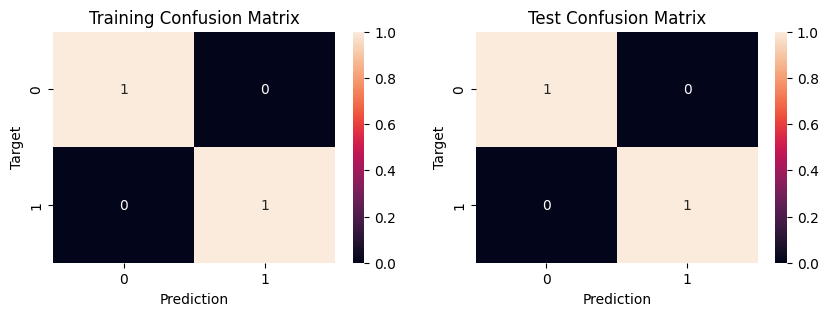

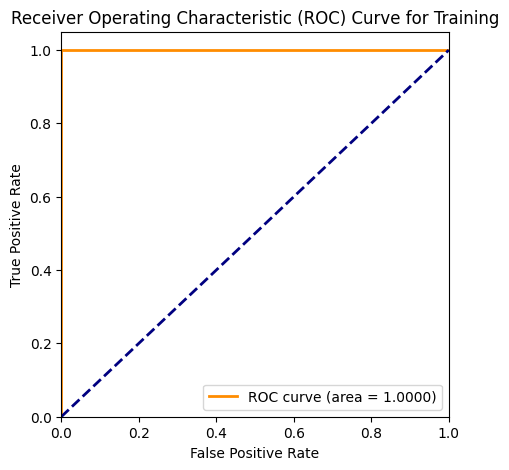

AUROC for Test: 1.0000


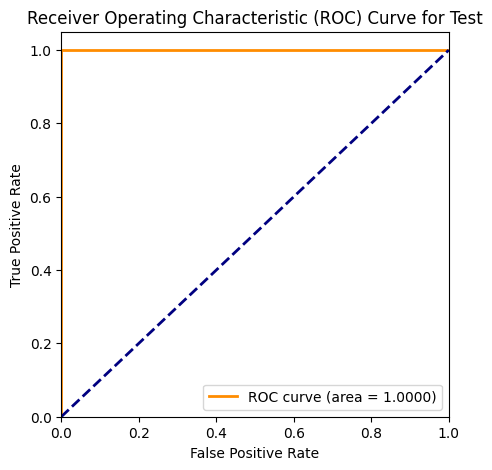

In [57]:
# Створення моделі
model_rnd_clf_t = RandomForestClassifier(n_estimators = 5,
                                         max_leaf_nodes = 16,
                                         n_jobs = -1,
                                         random_state = 42)

# Тренування моделі
model_rnd_clf_t.fit(X_train_t, y_train_t)

# Прогнозування моделі
train_pred_rnd_clf_t = model_rnd_clf_t.predict(X_train_t)
test_pred_rnd_clf_t  = model_rnd_clf_t.predict(X_test_t)

# Оцінка моделі
get_report(y_train_t, train_pred_rnd_clf_t, y_test_t, test_pred_rnd_clf_t)
predict_and_plot(y_train_t, y_test_t, train_pred_rnd_clf_t, test_pred_rnd_clf_t)
compute_auroc_and_build_roc(X_train_t, y_train_t, model_rnd_clf_t, 'Training')
compute_auroc_and_build_roc(X_test_t, y_test_t, model_rnd_clf_t, 'Test')

Без підбору параметрів модель ідеально прогнозує дані як на тренувальних, так і на тестувальних даних.

### Decision Tree

Training
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       216
           1     1.0000    1.0000    1.0000       118

    accuracy                         1.0000       334
   macro avg     1.0000    1.0000    1.0000       334
weighted avg     1.0000    1.0000    1.0000       334


Test
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        50
           1     1.0000    1.0000    1.0000        34

    accuracy                         1.0000        84
   macro avg     1.0000    1.0000    1.0000        84
weighted avg     1.0000    1.0000    1.0000        84

Training accuracy: 100.00%
F1 score Training: 1.00%
Test accuracy: 100.00%
F1 score Test: 1.00%
AUROC for Training: 1.0000


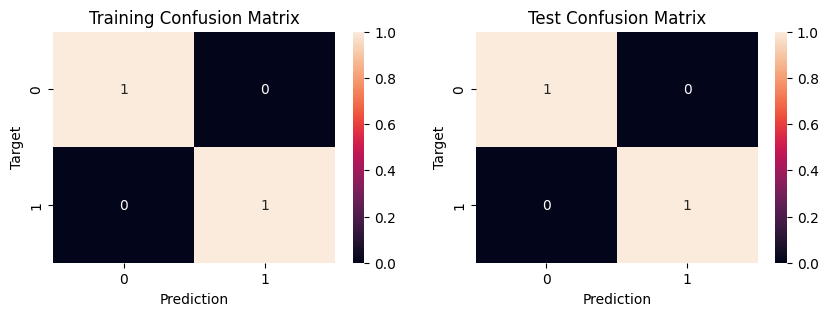

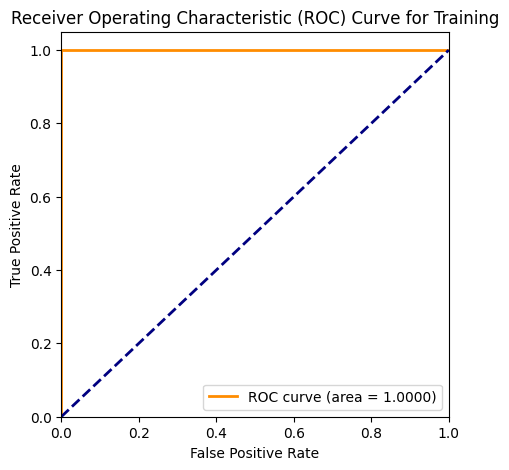

AUROC for Test: 1.0000


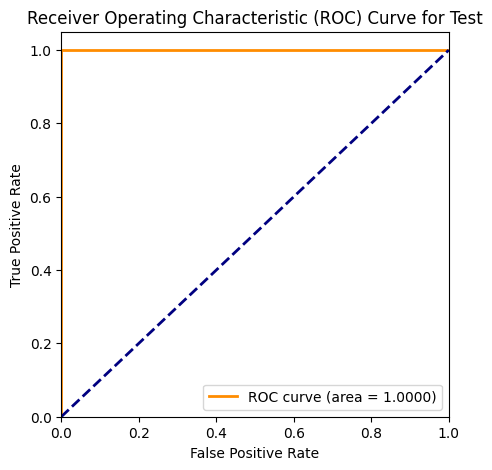

In [58]:
# Створення моделі
model_dt_t = DecisionTreeClassifier(random_state = 42)

# Тренування моделі
model_dt_t.fit(X_train_t, y_train_t)

# Прогнозування моделі
train_pred_dt_t = model_dt_t.predict(X_train_t)
test_pred_dt_t  = model_dt_t.predict(X_test_t)

# Оцінка моделі
get_report(y_train_t, train_pred_dt_t, y_test_t, test_pred_dt_t)
predict_and_plot(y_train_t, y_test_t, train_pred_dt_t, test_pred_dt_t)
compute_auroc_and_build_roc(X_train_t, y_train_t, model_dt_t, 'Training')
compute_auroc_and_build_roc(X_test_t, y_test_t, model_dt_t, 'Test')

Без підбору параметрів модель ідеально прогнозує дані як на тренувальних, так і на тестувальних даних.

## Висновки

Отже, без додаткового підбору гіперпараметрів всі три моделі ідеально прогнозують дані.